In [1]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import open3d as o3d

from src.utils.dataloader import load_ear_data
from src.utils.integrate import elementwise_dblquad, elementwise_circquad
from src.utils.viz import set_axes_equal

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
def clean_df(df):
    """Remove the points that correspond to the external surface of the
    Simulia/CST simulation domain.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Raw output Simulia/CST data.

    Returns
    -------
    pandas.DataFrame
        Electric and magnetic field components only at the ear surface.
    """
    df = df[(df['x [mm]'] != df['x [mm]'].min())
            & (df['x [mm]'] != df['x [mm]'].max())
            & (df['y [mm]'] != df['y [mm]'].min())
            & (df['y [mm]'] != df['y [mm]'].max())
            & (df['z [mm]'] != df['z [mm]'].min())
            & (df['z [mm]'] != df['z [mm]'].max())]
    df.reset_index(drop=True, inplace=True)
    return df


def export_pcd(df, area=False):
    """Convert the clean dataframe to point cloud.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Clean version of the dataframe consisting the Simulia/CST
        output data.
    area : Bool, optional
        If True, the output will have area of the finite element
        corresponding to the specific point.

    Returns
    -------
    numpy.ndarray
        Either array of shape (n, 3) where each column corresponds to
        x-, y-, and z-coordinates of the ear model, or array of shape
        (n, 4) where additional column corresponds to the area of the
        finite element corresponding to the specific point.
    """
    if area:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy(),
                    df['area [mm^2]'].to_numpy()]
    else:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy()]
    return pcd


def export_fields(df):
    """Convert the clean dataframe to array of electromagnetic field
    components.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Clean version of the dataframe consisting the Simulia/CST
        output data.

    Returns
    -------
    tuple
        First element of the tuple holds the 3 arrays for 3 components
        of the electric field vector, while the second element holds
        the 3 arrays each corresponding the the 3 components of the
        magnetic field vector.
    """
    Ex = df['ExRe [V/m]'].to_numpy() + 1j * df['ExIm [V/m]'].to_numpy()
    Ey = df['EyRe [V/m]'].to_numpy() + 1j * df['EyIm [V/m]'].to_numpy()
    Ez = df['EzRe [V/m]'].to_numpy() + 1j * df['EzIm [V/m]'].to_numpy()
    Hx = df['HxRe [A/m]'].to_numpy() + 1j * df['HxIm [A/m]'].to_numpy()
    Hy = df['HyRe [A/m]'].to_numpy() + 1j * df['HyIm [A/m]'].to_numpy()
    Hz = df['HzRe [A/m]'].to_numpy() + 1j * df['HzIm [A/m]'].to_numpy()
    return (Ex, Ey, Ez), (Hx, Hy, Hz)


def poynting_vector(E, H):
    """Return power density given x-, y-, and z-component of electric
    and magnetic field. It assumes that the given components are max
    values and all components of the power dansity are scaled by 1/2.
    
    Parameters
    ----------
    E : tuple
        3 arrays for 3 components of the electric field vector.
    H : tuple
        3 arrays for 3 components of the magnetic field vector.

    Returns
    -------
    tuple
        Containg 3 arrays for 3 components of the Poynting vector.
    """
    Sx = 0.5 * (E[1] * H[2].conjugate() - E[2] * H[1].conjugate())
    Sy = 0.5 * (E[2] * H[0].conjugate() - E[0] * H[2].conjugate())
    Sz = 0.5 * (E[0] * H[1].conjugate() - E[1] * H[0].conjugate())
    return Sx, Sy, Sz


def prettify_viz():
    """Adjust coloring and style for visualization.
    
    Parameters
    ----------
    None

    Returns
    -------
    None
    """
    import seaborn as sns
    sns.set(style='ticks', palette='colorblind')
    %config InlineBackend.figure_format = 'retina'


def plot_2d(xy_dict, figsize=plt.rcParams['figure.figsize'],
            markersize=plt.rcParams['lines.markersize']**2, c=None, alpha=1):
    """2-D scatter plot.
    
    Parameters
    ----------
    xy_dict : dictionary
        Keys are label names, values are the corresponding values.
        First input goes on the x-axis, the second one goes on the
        y-axis, and the third one, if exists, defines the color of each
        marker.
    figsize : tuple, optional
        Width, height in inches.
    markersize : float or array-like, optional
        The marker size.
    c : string, optional
        The marker color. If set, it overrides the third input of
        `xy_dict`.
    alpha : float, optional
        The alpha blending value, between 0 (transparent) and 1
        (opaque).

    Returns
    -------
    tuple
        Figure and axes of the 2-D scatter plot.
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    keys = list(xy_dict.keys())
    values = list(xy_dict.values())
    if (len(values) == 3) and not(c):
        cs = ax.scatter(values[0], values[1], s=markersize, c=values[2],
                        cmap='viridis')
        cbar = fig.colorbar(cs)
        cbar.ax.set_ylabel(keys[2])
    else:
        if not(c):
            c = 'k'
        cs = ax.scatter(values[0], values[1], s=markersize, c=c, alpha=alpha)
    ax.set(xlabel=keys[0], ylabel=keys[1])
    
    ax.axis('equal')
    fig.tight_layout()
    return fig, ax


def plot_3d(xyz_dict, figsize=(7, 7), elev=[20], azim=[45], c=None, alpha=1):
    """2-D scatter plot.
    
    Parameters
    ----------
    xyz_dict : dictionary
        Keys are label names, values are the corresponding values.
        First three inputs go on the x-, y-, and z-axis, respectively,
        while the forth one, if exists, defines the color of each
        marker.
    figsize : tuple, optional
        Width, height in inches.
    azim : list of floats, optional
        Azimuthal viewing angle. If there are more than 1 element in
        the list, the multiple subplots will be generated.
    elev : list of floats, optional
        Elevation viewing angle. If there are more than 1 element in
        the list, the multiple subplots will be generated.
    c : string, optional
        The marker color. If set, it overrides the forth input in
        `xyz_dict`.
    alpha : float, optional
        The alpha blending value, between 0 (transparent) and 1
        (opaque).

    Returns
    -------
    tuple
        Figure and axes of the 2-D scatter plot.
    """
    from itertools import product
    num_figs = len(elev) * len(azim)
    if num_figs > 4:
        raise ValueError('The max number of subplots is 4.')
    if num_figs != 1:
        figsize = (figsize[0] * num_figs / 2, figsize[1] * num_figs / 2)
    fig = plt.figure(figsize=figsize)
    keys = list(xyz_dict.keys())
    values = list(xyz_dict.values())
    for i, (e, a) in enumerate(product(elev, azim)):
        ax = fig.add_subplot(num_figs, 1, i+1, projection='3d')
        if (len(values) == 4) and not(c):
            cs = ax.scatter(values[0], values[1], values[2],
                            c=values[3], cmap='viridis')
            cbar = fig.colorbar(cs, shrink=0.5, pad=0.1)
            cbar.ax.set_ylabel(keys[3])
        else:
            if not(c):
                c = 'k'
            cs = ax.plot(values[0], values[1], values[2], '.', c=c, alpha=alpha)
        ax.set(xlabel=keys[0], ylabel=keys[1], zlabel=keys[2])
        ax = set_axes_equal(ax)
        ax.view_init(elev=e, azim=a)
    fig.tight_layout()
    return fig, ax


def minmax_scale(x, _range=(0, 1)):
    """Min-max scaler.
    
    Parameters
    ----------
    x : numpy.ndarray
        The data to be scaled.
    _range : tuple, optional
        Desired range of transformed data.

    Returns
    -------
    numpy.ndarray
        Scaled data.
    """
    scaler = (x - x.min()) / (x.max() - x.min())
    x_scaled = scaler * (_range[1] - _range[0]) + _range[0]
    return x_scaled


def colormap_from_array(x, cmap='viridis', alpha=None, bytes=False):
    """Min-max scaler.
    
    Parameters
    ----------
    x : numpy.ndarray
        The data to convert to a RGB.
    cmap : string, optional
        Name of the colormap.
    alpha : float, optional
        The alpha blending value, between 0 (transparent) and 1
        (opaque).
    bytes : bool, optional
        If False (default), the returned RGBA values will be floats in
        the interval [0, 1] otherwise they will be uint8s in the
        interval [0, 255].

    Returns
    -------
    numpy.ndarray
        An array of RGB values.
    """
    from matplotlib import cm
    x_scaled = minmax_scale(x)
    try:
        cs = eval(f'cm.{cmap}')(x_scaled, alpha, bytes)
    except Exception as e:
        print(e, 'Falling to default colormap')
        cs = cm.viridis(x_scaled, alpha, bytes)
    finally:
        if alpha is None:
            cs = cs[:, :3]
    return cs


def estimate_normals(xyz, take_every=1, knn=30, fast=True):
    """Return estimated normals for a given point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    take_every : int, optional
        How many points to skip in the point cloud when estimating
        normal vectors.
    knn : int, optional
        Number of neighbors for KDTree search.
    fast : bool, optional
        If True, the normal estimation uses a non-iterative method to
        extract the eigenvector from the covariance matrix. This is
        faster, but is not as numerical stable.

    Returns
    -------
    numpy.ndarray
        The number of rows correspond to the number of rows of a given
        point cloud, and each column corresponds to each component of
        the normal vector.
    """
    import open3d as o3d
    xyz = xyz[::take_every, :]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn),
                         fast_normal_computation=fast)
    pcd.normalize_normals()
    n = np.asarray(pcd.normals)
    return n


def avg_rect_zy_plane(xyz, center, edge_length):
    """Extract specific points that correspond to a rectangle, defined
    with a central point and its edge length, from a point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    center : tuple or list
        z- and y-coordinate that defines the center of a desired
        rectangle.
    edge_length : float
        Edge length of a desired rectangle.

    Returns
    -------
    tuple
        Origin, width, height of a desired rectangle and indexes
        of all points from a point cloud that falls into a rectangle.
    """
    z_bound = [center[0] - edge_length / 2,
               center[0] + edge_length / 2]
    y_bound = [center[1] - edge_length / 2,
               center[1] + edge_length / 2]
    origin = [z_bound[0], y_bound[0]]
    width = z_bound[1] - z_bound[0]
    height = y_bound[1] - y_bound[0]
    idx_rect = np.where((xyz[:, 2] > z_bound[0])
                        & (xyz[:, 2] < z_bound[1])
                        & (xyz[:, 1] > y_bound[0])
                        & (xyz[:, 1] < y_bound[1]))[0]
    return origin, width, height, idx_rect


def avg_circ_zy_plane(xyz, center, radius):
    """Extract specific points that correspond to a disk, defined
    with a central point and its radius, from a point cloud.
    
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    center : tuple or list
        z- and y-coordinate that defines the center of a desired
        disk.
    radius : float
        Radius of a desired disk.

    Returns
    -------
    numpy.ndarray
        Indexes of all points from a point cloud that falls into a
        circle describing a disk.
    """
    cz, cy = center
    idx_circ = np.where(
        (xyz[:, 2] - cz) ** 2 + (xyz[:, 1] - cy) ** 2 < radius ** 2)[0]
    return idx_circ


def diff_in_dB(apd1, apd2):
    """Return the difference in dB between two values for the power.
    
    Parameters
    ----------
    apd1 : float or numpy.ndarray
        Absorbed power density, or anything else measured in Watts.
    apd2 : float or numpy.ndarray
        Absorbed power density, or anything else measured in Watts to
        be compared to `apd1`.

    Returns
    -------
    float or numpy.ndarray
        Difference(s) in dB between two (arrays of) values of the
        power.
    """
    diff = np.abs(10 * np.log10(apd1 / apd2))
    return diff

In [3]:
prettify_viz()

In [4]:
PROJECT_NAME = 'IMBioC2022_paper'

In [5]:
df = load_ear_data('te', 60)
df = clean_df(df)
df

INFO - 2021-12-09 14:15:52,379 - utils - NumExpr defaulting to 4 threads.


,x [mm],y [mm],z [mm],ExRe [V/m],ExIm [V/m],EyRe [V/m],EyIm [V/m],EzRe [V/m],EzIm [V/m],HxRe [A/m],HxIm [A/m],HyRe [A/m],HyIm [A/m],HzRe [A/m],HzIm [A/m],area [mm^2]
0,68.086311,-2.688804,6.271268,1.232110,-5.230014,-0.854390,-2.007048,-1.674893,1.056376,-0.003978,0.015257,0.006635,0.069231,0.012686,0.013412,0.021413
1,68.137262,-1.882788,6.271268,0.110677,-4.952678,0.181903,1.913511,0.233148,-0.185610,0.012695,0.016883,0.020533,0.040169,0.001112,0.000054,0.021204
2,68.137262,-1.661499,6.271268,-0.158298,-4.748529,0.768468,1.654867,0.411543,-0.230130,0.016060,0.011812,0.020303,0.035178,0.000582,0.001067,0.021204
3,68.137262,-1.440210,6.271268,-0.433497,-4.280247,1.174487,1.214872,0.532638,-0.263018,0.017855,0.005253,0.020103,0.031797,0.001083,0.001507,0.021204
4,68.137262,-1.218921,6.271268,-0.632277,-4.512611,1.366378,0.712167,0.600204,-0.543568,0.016926,-0.000357,0.019053,0.030942,0.001624,0.001248,0.021204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235895,78.963859,23.625316,-19.634544,-54.406391,50.005753,-1.355134,1.343070,-4.986677,-7.405610,0.003381,-0.002889,-0.145401,0.135739,-0.001949,0.003562,0.018991
235896,78.991476,23.313006,-19.562917,-49.443726,55.848423,-0.922195,0.994825,-6.457432,-6.518611,0.002314,-0.002010,-0.132701,0.148280,-0.000963,0.002942,0.021192
235897,79.020337,23.324603,-19.438831,-39.981647,64.021866,-0.715655,1.295890,-8.591330,-3.589297,0.002183,-0.002558,-0.107785,0.166156,-0.001015,0.003337,0.021145
235898,79.010733,23.544151,-19.453349,-41.346844,63.000320,-1.009556,1.707334,-8.313073,-3.887859,0.002853,-0.003285,-0.110526,0.163981,-0.001588,0.003888,0.020441


In [6]:
xyz = export_pcd(df)
E, H = export_fields(df)

In [7]:
Sx, Sy, Sz = poynting_vector(E, H)

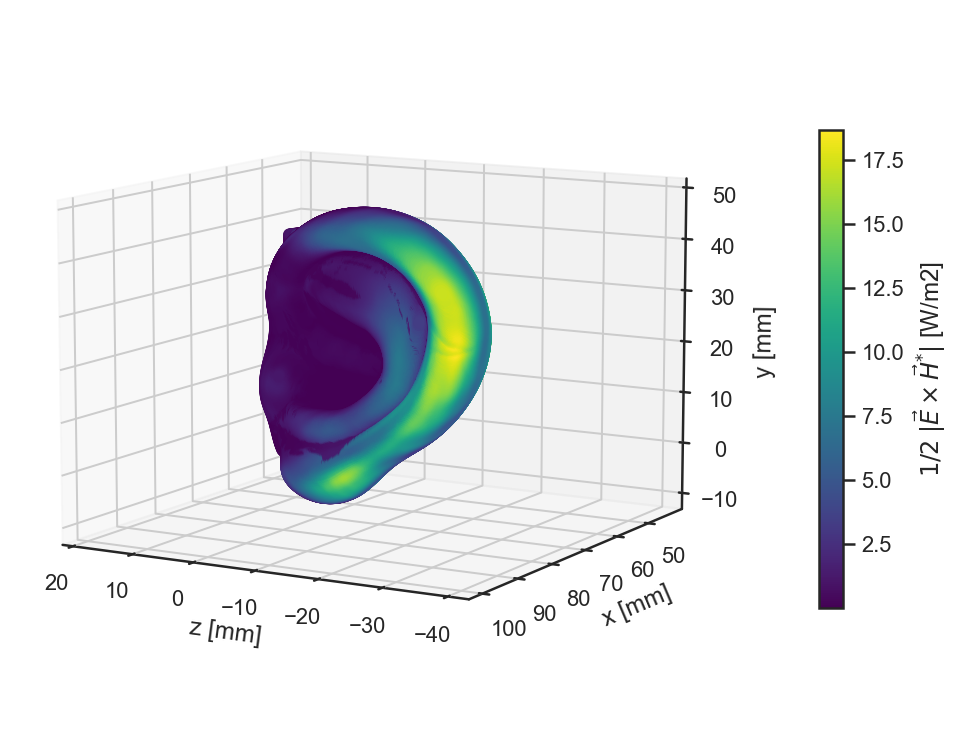

In [8]:
S = abs(np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2))
S_label = r'$1/2$ $|\vec{E}\times\vec{H}^{*}|$ [W/m2]'
fig, ax = plot_3d({'z [mm]': xyz[:, 2],
                   'x [mm]': xyz[:, 0],
                   'y [mm]': xyz[:, 1],
                   S_label: S},
                  elev=[10], azim=[120])

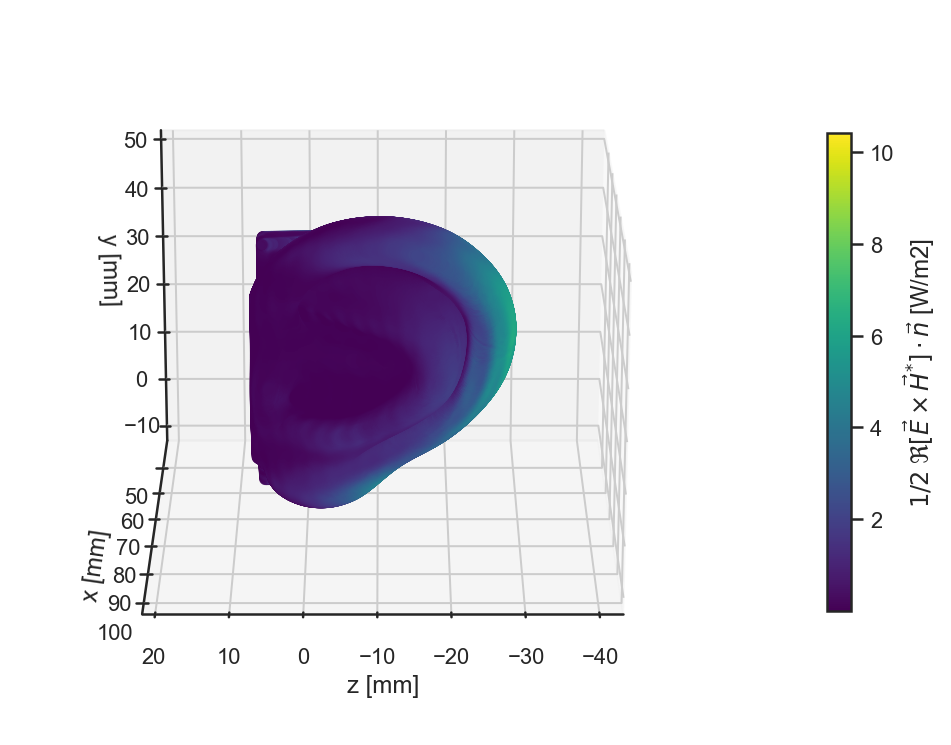

In [9]:
n = estimate_normals(xyz, knn=30, fast=True)
Sr = abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])
Sr_label = r'$1/2$ $\Re{[\vec{E}\times\vec{H}^{*}]} \cdot \vec{n}$ [W/m2]'
fig, ax = plot_3d({'z [mm]': xyz[:, 2],
                   'x [mm]': xyz[:, 0],
                   'y [mm]': xyz[:, 1],
                   Sr_label: Sr},
                  elev=[20], azim=[90])

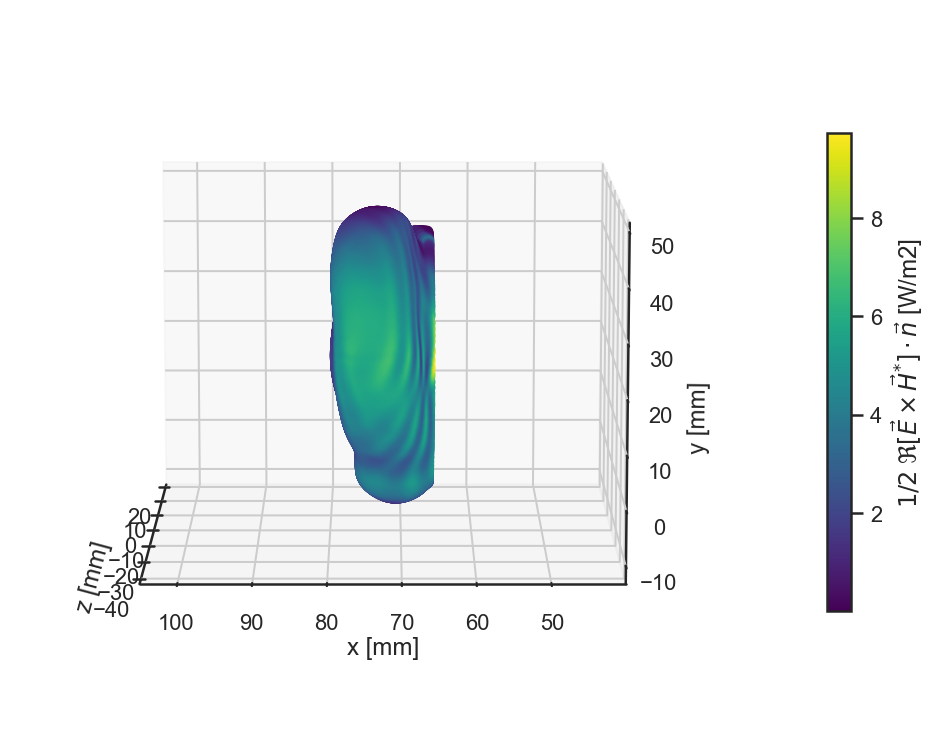

In [10]:
crop_idxs = np.where(xyz[:, 0] > 66)[0]
xyz_crop = xyz[crop_idxs]
Sx_crop, Sy_crop, Sz_crop = Sx[crop_idxs], Sy[crop_idxs], Sz[crop_idxs]
n_crop = estimate_normals(xyz_crop, knn=30, fast=True)
Sr_crop = abs(Sx_crop.real * n_crop[:, 0]
              + Sy_crop.real * n_crop[:, 1]
              + Sz_crop.real * n_crop[:, 2])
fig, ax = plot_3d({'z [mm]': xyz_crop[:, 2],
                   'x [mm]': xyz_crop[:, 0],
                   'y [mm]': xyz_crop[:, 1],
                   Sr_label: Sr_crop},
                  elev=[10], azim=[180])

In [11]:
# copy the data
points = xyz.copy()
normals = n.copy()
APD = Sr.copy()

In [12]:
# define coordinate frame
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
center = pcd.get_center()
pcd.paint_uniform_color([0.5, 0.5, 0.5])
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                           origin=center)
# o3d.visualization.draw_geometries([cframe, pcd])

In [13]:
# translate data to have a center at (0, 0, 0)
xyz_t = np.c_[points[:, 0] - center[0],
              points[:, 1] - center[1],
              points[:, 2] - center[2]]
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(xyz_t)
center_t = pcd_t.get_center()
pcd_t.paint_uniform_color([0.5, 0.5, 0.5])
cframe_t = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                             origin=center_t)
# o3d.visualization.draw_geometries([cframe_t, pcd_t])

In [16]:
# select x-visible indices
diameter = np.linalg.norm(pcd_t.get_max_bound() - pcd_t.get_min_bound())
radius = 10 ** 5.5
camera = [diameter, 0, 0]

_, pt_map = pcd_t.hidden_point_removal(camera, radius)

xyz_t_zy_plane = xyz_t[pt_map]
APD_t_zy_plane = APD[pt_map]
pcd_t_zy_plane = o3d.geometry.PointCloud()
pcd_t_zy_plane.points = o3d.utility.Vector3dVector(xyz_t_zy_plane)
pcd_t_zy_plane.colors = o3d.utility.Vector3dVector(colormap_from_array(APD_t_zy_plane))
# o3d.visualization.draw_geometries([cframe_t, pcd_t_zy_plane])

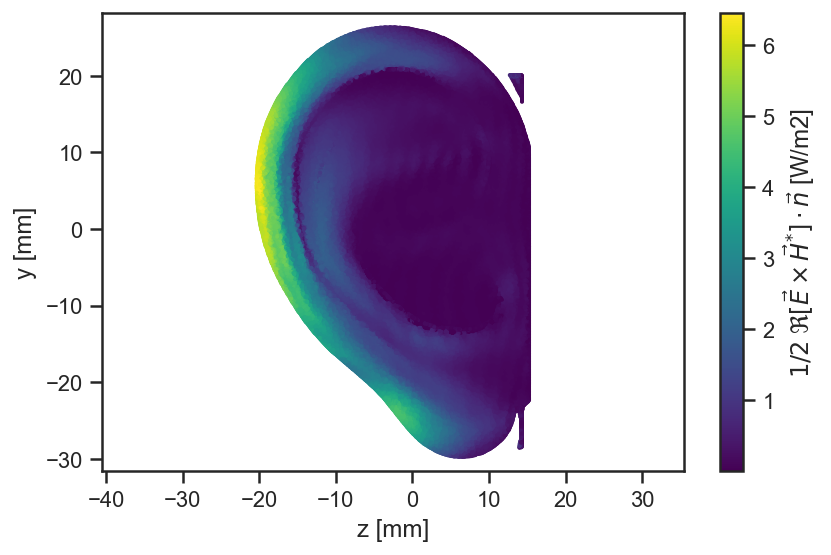

In [17]:
# zy plane in 2-D
fig, ax = plot_2d({'z [mm]': xyz_t_zy_plane[:, 2],
                   'y [mm]': xyz_t_zy_plane[:, 1],
                   Sr_label: APD_t_zy_plane}, markersize=1)

In [18]:
# create target suface area for averaging of a rectangular shape
center = [-12.5, 12.5]
origin, width, height, idx_rect = avg_rect_zy_plane(xyz=xyz_t_zy_plane,
                                                    center=center,
                                                    edge_length=10)
area = width * height
xyz_rect = xyz_t_zy_plane[idx_rect]
APD_rect = APD_t_zy_plane[idx_rect]

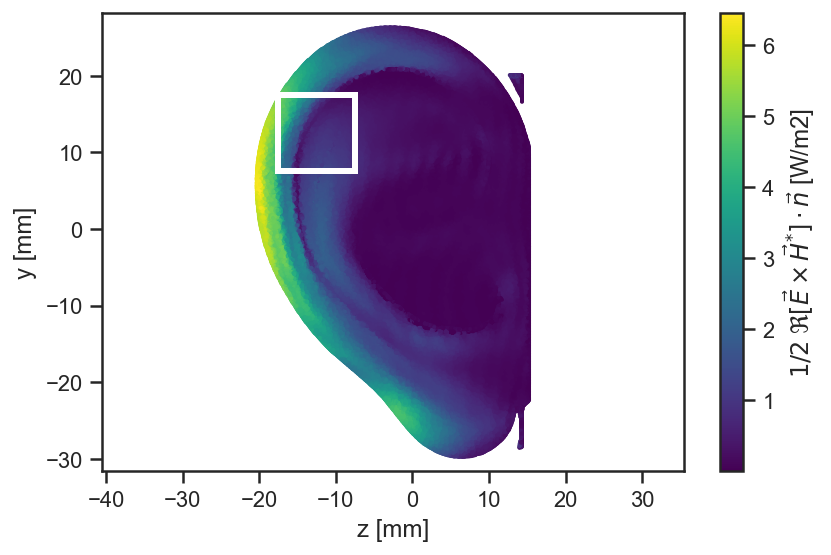

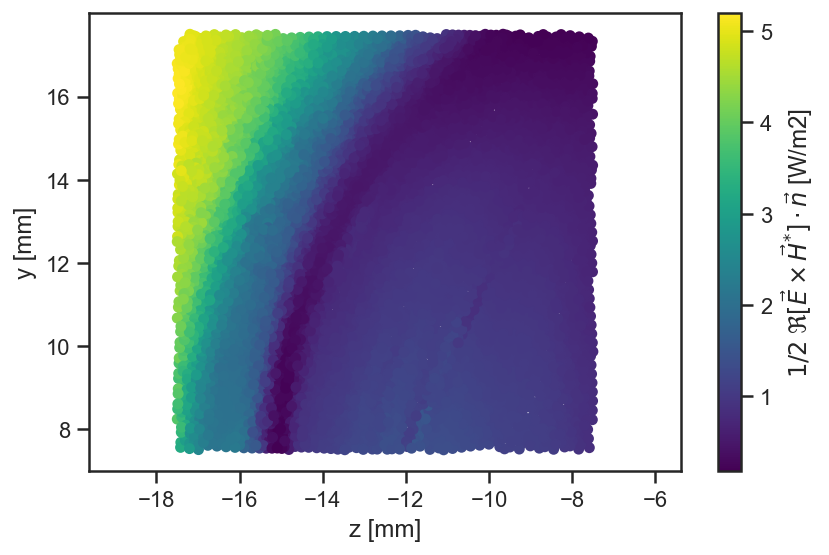

In [19]:
# first figure of the rectangle target surface area for averaging
fig, ax = plot_2d({'z [mm]': xyz_t_zy_plane[:, 2],
                   'y [mm]': xyz_t_zy_plane[:, 1],
                   Sr_label: APD_t_zy_plane}, markersize=1)
avg_surf = ax.add_patch(Rectangle(origin, width, height, fc='None', lw=3));

# second figure, zoom in
fig, ax = plot_2d({'z [mm]': xyz_rect[:, 2],
                   'y [mm]': xyz_rect[:, 1],
                   Sr_label: APD_rect}, markersize=20);

In [20]:
# computing the averaged APD
APD_avg_rect = elementwise_dblquad(points=np.c_[xyz_rect[:, 2], xyz_rect[:, 1]],
                                   values=APD_rect,
                                   leggauss_deg=11) / area
print(f'APD_avg = {APD_avg_rect:.7f} W/m2')

APD_avg = 1.5420126 W/m2


In [21]:
# create target suface area for averaging of a circular shape

radius = np.sqrt(area / np.pi)
idx_circ = avg_circ_zy_plane(xyz=xyz_t_zy_plane,
                             center=center,
                             radius=radius)
xyz_circ = xyz_t_zy_plane[idx_circ]
APD_circ = APD_t_zy_plane[idx_circ]

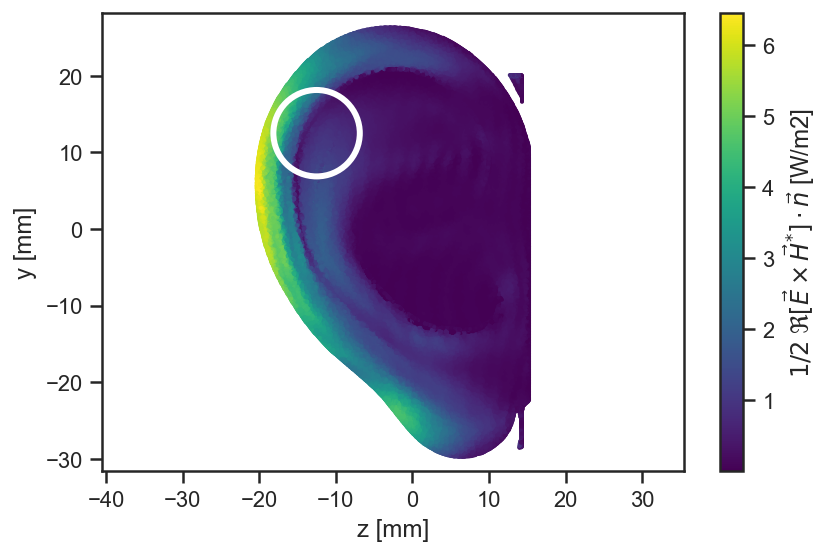

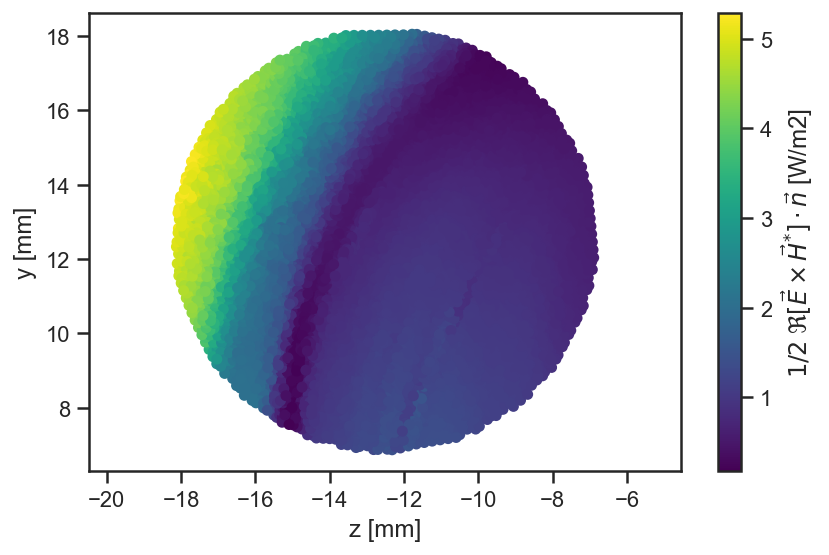

In [22]:
# first figure of the circular target surface area for averaging
fig, ax = plot_2d({'z [mm]': xyz_t_zy_plane[:, 2],
                   'y [mm]': xyz_t_zy_plane[:, 1],
                   Sr_label: APD_t_zy_plane}, markersize=1)
avg_surf = ax.add_patch(Circle(center, radius, fc='None', lw=3));

# zoom in
fig, ax = plot_2d({'z [mm]': xyz_circ[:, 2],
                   'y [mm]': xyz_circ[:, 1],
                   Sr_label: APD_circ}, markersize=20);

In [23]:
# computing the averaged APD
APD_avg_circ = elementwise_circquad(points=np.c_[xyz_circ[:, 2], xyz_circ[:, 1]],
                                    values=APD_circ,
                                    radius=radius,
                                    center=center,
                                    degree=11) / area
print(f'APD_avg = {APD_avg_circ:.7f} W/m2')

APD_avg = 1.5246101 W/m2


In [24]:
print(f'APD_diff = {diff_in_dB(APD_avg_rect, APD_avg_circ):.7f} dB')

APD_diff = 0.0492910 dB
